In [4]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
from actsnfink.classifier_sigmoid import get_sigmoid_features_elasticc_perfilter, fit_sigmoid
from actsnfink.classifier_sigmoid import mask_negative_data, average_intraday_data, get_ewma_derivative
from progressbar import progressbar
from actsnfink.sigmoid import fsigmoid, delta_t

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk') 

In [5]:
taxonomy = {111: 'Ia',
           112: 'Ibc',
           113: 'II',
           114: 'Iax',
           115: '91bg',
           120: 'FastOther',
           121: 'KN',
           122: 'Mdwarf',
           123: 'DwarfNovae',
           124: 'mLens',
           130: 'LongOther',
           131: 'SLSN',
           132: 'TDE',
           133: 'ILOT',
           134: 'CART',
           135: 'PISN',
           210: 'PeriodicOther',
           211: 'Cepheid',
           212: 'RRLyrae',
           213: 'dScuti',
           214: 'EB',
           215: 'LPVMira',
           220: 'NonPeriodicOther',
           221: 'AGN'}


In [6]:
bands = ['u', 'g', 'r', 'i', 'z', 'Y']

In [7]:
def extract_history(history_list: list, field: str) -> list:
    """Extract the historical measurements contained in the alerts
    for the parameter `field`.

    Parameters
    ----------
    history_list: list of dict
        List of dictionary from alert[history].
    field: str
        The field name for which you want to extract the data. It must be
        a key of elements of history_list
    
    Returns
    ----------
    measurement: list
        List of all the `field` measurements contained in the alerts.
    """
    if history_list is None:
        return []
    try:
        measurement = [obs[field] for obs in history_list]
    except KeyError:
        print('{} not in history data'.format(field))
        measurement = []

    return measurement

def extract_field(alert: dict, category: str, field: str) -> np.array:
    """ Concatenate current and historical observation data for a given field.
    
    Parameters
    ----------
    alert: dict
        Dictionnary containing alert data
    category: str
        prvDiaSources or prvDiaForcedSources
    field: str
        Name of the field to extract.
    
    Returns
    ----------
    data: np.array
        List containing previous measurements and current measurement at the
        end. If `field` is not in the category, data will be
        [alert['diaSource'][field]].
    """
    data = np.concatenate(
        [
            [alert["diaSource"][field]],
            extract_history(alert[category], field)
        ]
    )
    return data

In [8]:
class_id = 111
dirname = '/media/ELAsTICC/Fink/first_year/ftransfer_elasticc_2023-02-15_946675/' + \
        'classId=' + str(class_id) + '/'
flist = os.listdir(dirname)

In [9]:
len(flist)

17239

In [ ]:
cols = ['alertId', 'classId', 'cmidPointTai', 'cpsFlux', 'cpsFluxErr', 'cfilterName']
extra_cols = ['diaObjectId', 'hostgal_dec', 'hostgal_ra', 'hostgal_snsep', 'hostgal_zphot', 'hostgal_zphot_err',
              'mwebv','mwebv_err', 'ra', 'decl']

data = []

for fname in progressbar(flist):

    fname = dirname + fname
    pdf = pd.read_parquet(fname)
    pdf['classId'] = 111

    pdf['cpsFlux'] = pdf[['diaSource', 'prvDiaForcedSources']]\
            .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'psFlux'), axis=1)
    pdf['cpsFluxErr'] = pdf[['diaSource', 'prvDiaForcedSources']]\
            .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'psFluxErr'), axis=1)
    pdf['cfilterName'] = pdf[['diaSource', 'prvDiaForcedSources']]\
            .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'filterName'), axis=1)
    pdf['cmidPointTai'] = pdf[['diaSource', 'prvDiaForcedSources']]\
            .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'midPointTai'), axis=1)

    sub = deepcopy(pdf[cols])

    for name in extra_cols:
        sub[name] = [pdf['diaObject'][i][name] for i in range(len(pdf['diaObject']))]
        
    if sub.shape[0] > 0:
        data.append(sub)

data_pd = pd.concat(data, ignore_index=True)

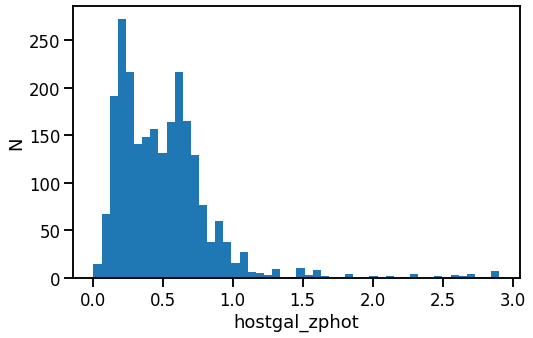

In [6]:
plt.figure(figsize=(8,5))
plt.hist(data_pd['hostgal_zphot'][data_pd['hostgal_zphot'].values > -200], bins=50)
plt.xlabel('hostgal_zphot')
plt.ylabel('N')
plt.show()

In [7]:
flat_fluxerr = []
for i in range(data_pd['cpsFluxErr'].values.shape[0]):
    flat_fluxerr = flat_fluxerr + list(data_pd['cpsFluxErr'].values[i])

In [8]:
min(flat_fluxerr)

76.69490814208984

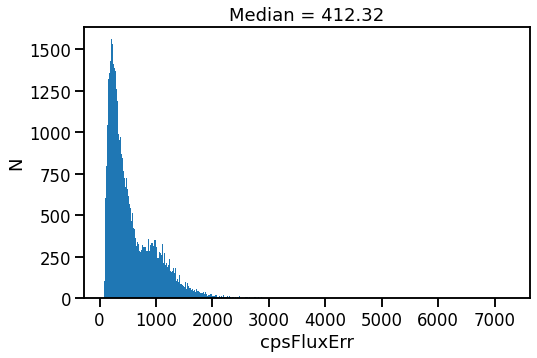

In [9]:
plt.figure(figsize=(8,5))
plt.title('Median = ' + str(np.round(np.median(flat_fluxerr),2)))
plt.hist(np.array(flat_fluxerr), bins=500)
plt.xlabel('cpsFluxErr')
plt.ylabel('N')
plt.show()

In [10]:
snr = []
for i in range(data_pd['cpsFluxErr'].values.shape[0]):
    for j in range(data_pd['cpsFluxErr'].values[i].shape[0]):
        snr.append(data_pd['cpsFlux'].values[i][j]/data_pd['cpsFluxErr'].values[i][j])

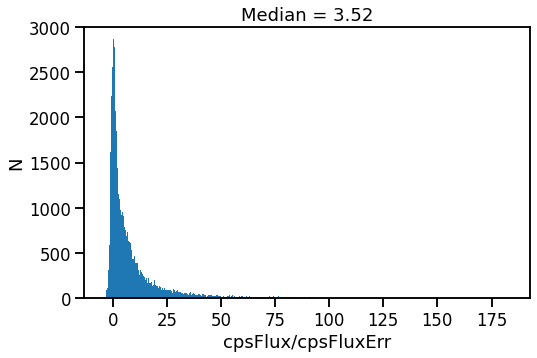

In [11]:
plt.figure(figsize=(8,5))
plt.title('Median = ' + str(np.round(np.median(snr),2)))
plt.hist(np.array(snr), bins=500)
plt.xlabel('cpsFlux/cpsFluxErr')
plt.ylabel('N')
plt.show()

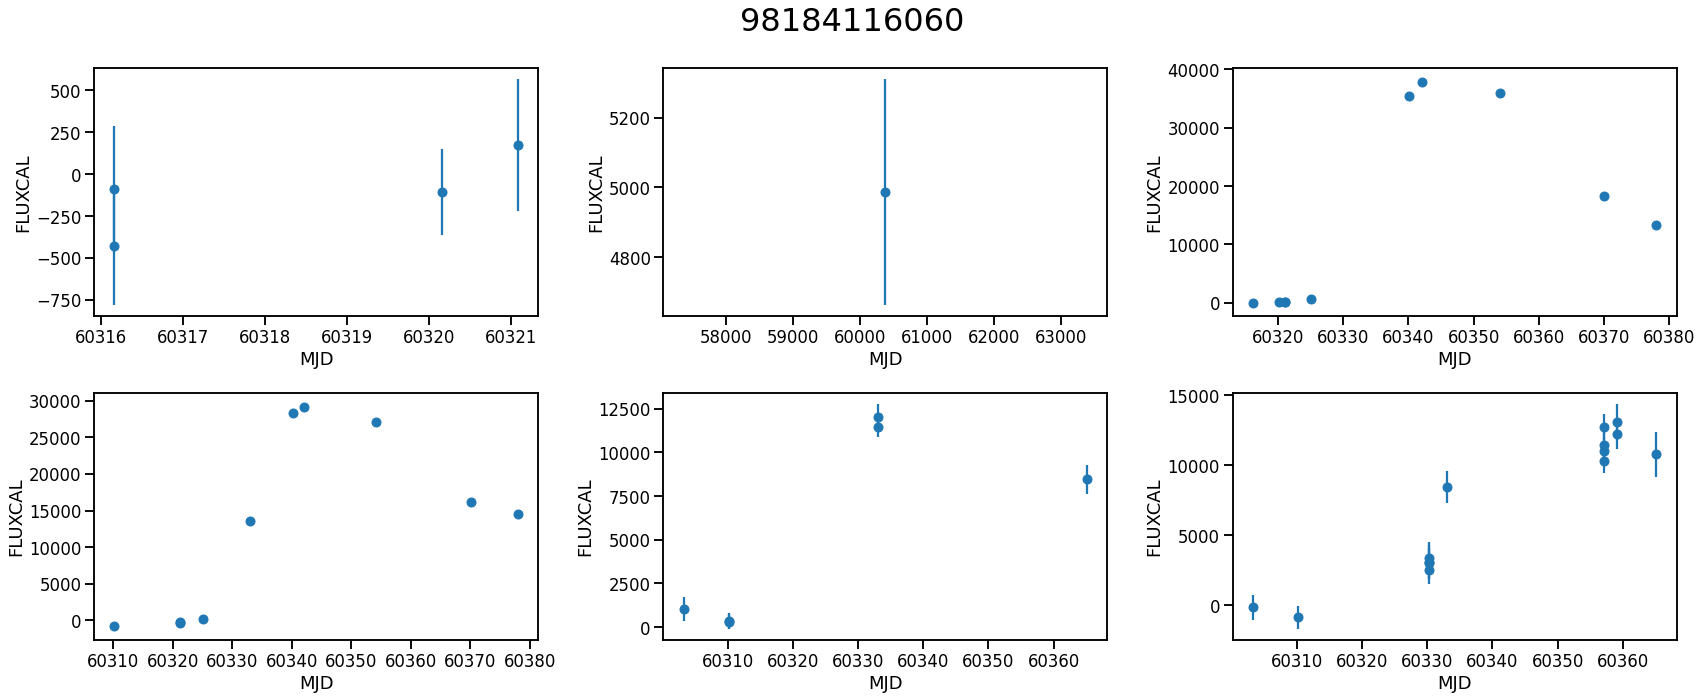

In [37]:
indx = 555 #np.random.choice(np.arange(data_pd.shape[0])) #555

plt.figure(figsize=(24,10))
plt.suptitle(data_pd.iloc[indx]['alertId'], fontsize=32)

for i in range(len(bands)):
    
    flag = data_pd.iloc[indx]['cfilterName'] == bands[i]
    
    if sum(flag) > 0:
        x = data_pd.iloc[indx]['cmidPointTai'][flag]
        y = data_pd.iloc[indx]['cpsFlux'][flag]
        yerr = data_pd.iloc[indx]['cpsFluxErr'][flag]
    
        plt.subplot(2, 3, i+1)
        plt.errorbar(x, y, yerr=yerr, fmt='o')
        plt.xlabel('MJD')
        plt.ylabel('FLUXCAL')
    
plt.tight_layout()
plt.show()
    

In [38]:
lc1 = pd.DataFrame()
lc1['MJD']= data_pd.iloc[indx]['cmidPointTai']
lc1['FLUXCAL'] = data_pd.iloc[indx]['cpsFlux']
lc1['FLUXCALERR'] = data_pd.iloc[indx]['cpsFluxErr']
lc1['FLT'] = data_pd.iloc[indx]['cfilterName']

In [39]:
features = get_sigmoid_features_elasticc_perfilter(lc1, list_filters=bands)

In [40]:
x = {}
y = {}

for i in range(len(bands)):
    
    flag = lc1['FLT'].values == bands[i]
    
    if sum(flag) > 0 and 0 not in features[i*6 : 3+i*6]:
        xaxis = np.arange(0, max(lc1['MJD'][flag]) - \
                          min(lc1['MJD'][flag]), 0.25)
        yaxis = fsigmoid(xaxis, features[i * 6], 
                                features[1 + i * 6], 
                                features[2 + i * 6])
        
        x[bands[i]] = xaxis
        y[bands[i]] = yaxis
    else:
        x[bands[i]] = []
        y[bands[i]] = []

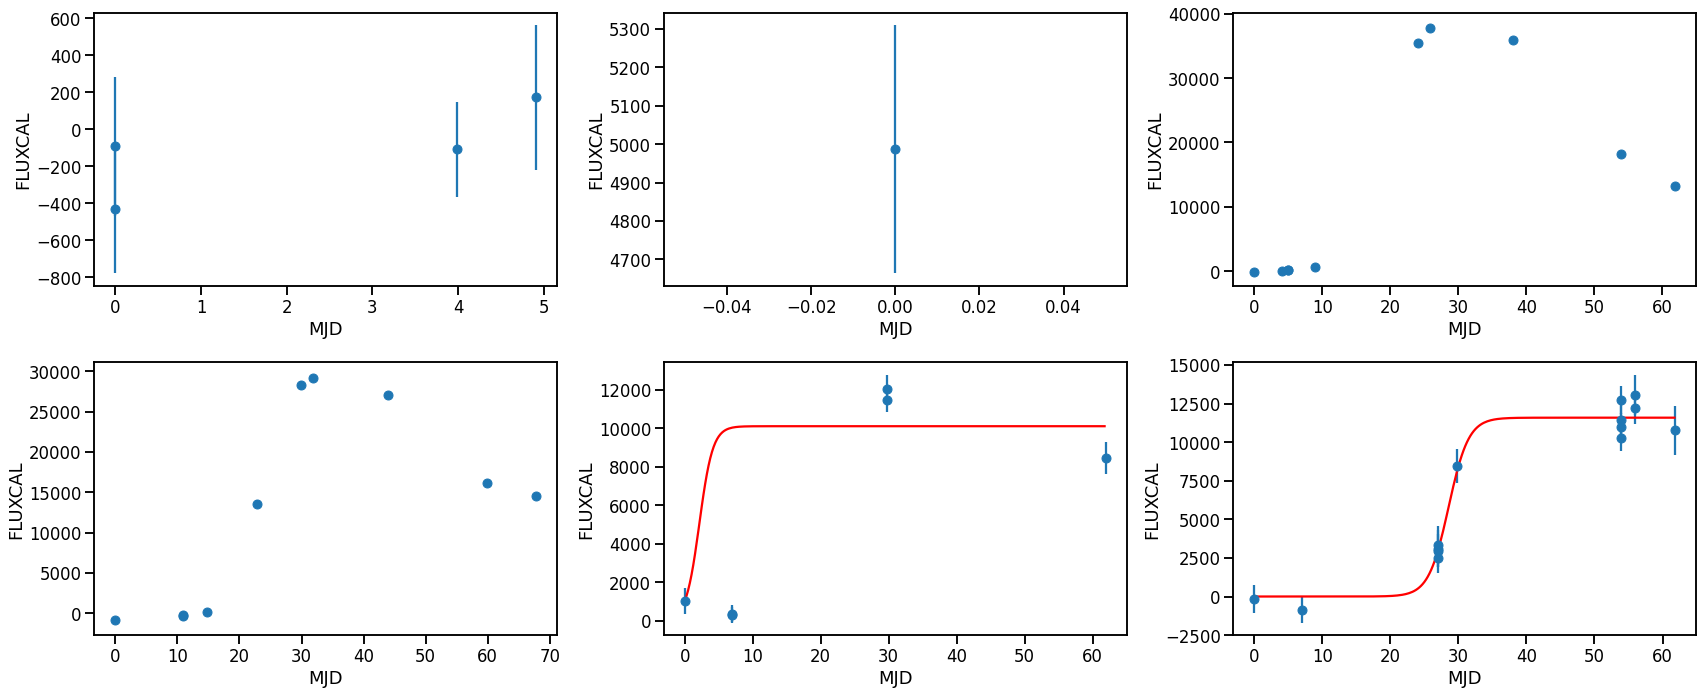

In [41]:
plt.figure(figsize=(24,10))

for i in range(len(bands)):
    
    flag = lc1['FLT'].values == bands[i]
    plt.subplot(2,3,i+1)
    if sum(flag) > 0:
        plt.errorbar(lc1['MJD'][flag] - min(lc1['MJD'][flag]), 
                     lc1['FLUXCAL'][flag], yerr=lc1['FLUXCALERR'][flag],
                     fmt='o')
        plt.plot(x[bands[i]], y[bands[i]], color='red')
    plt.xlabel('MJD')
    plt.ylabel('FLUXCAL')
    
plt.tight_layout()
plt.show()

# Check objects surviving feature extraction

In [14]:
dir_name = '/media/ELAsTICC/Fink/first_year/early_SNIa/all_features/'
flist = os.listdir(dir_name)
flist.remove('.ipynb_checkpoints')

In [15]:
input_dir = '/media/ELAsTICC/Fink/first_year/early_SNIa/all_features/'

flist = os.listdir(input_dir)
flist.remove('.ipynb_checkpoints')

data_list = []
for fname in flist:
    data_temp = pd.read_csv(input_dir + fname, index_col=False)
    
    col_remove = []
    for colname in data_temp.keys():
        if 'Unnamed' in colname:
            col_remove.append(colname)
            
    if len(col_remove) > 0:
        data_temp.drop(columns=col_remove, inplace=True)

    data_list.append(data_temp)
    
    print(fname, len(data_temp.keys()), data_temp.shape[0], np.unique(data_temp['classId'].values))
    
data_pd = pd.concat(data_list, ignore_index=True)

print('Total: ', data_pd.shape[0])

class_111.csv 48 2507323 [111]
class_131.csv 48 170026 [131]
class_212.csv 48 2230557 [212]
class_214.csv 48 1301841 [214]
class_124.csv 48 12923 [124]
class_123.csv 48 4023 [123]
class_135.csv 48 2761 [135]
class_213.csv 48 429117 [213]
class_221.csv 48 453542 [221]
class_113.csv 48 2451398 [113]
class_115.csv 48 49795 [115]
class_133.csv 48 4043 [133]
class_132.csv 48 30705 [132]
class_121.csv 48 5 [121]
class_134.csv 48 12833 [134]
class_211.csv 48 47713 [211]
class_112.csv 48 583007 [112]
class_114.csv 48 60497 [114]
Total:  10352109


In [16]:
data_pd.keys()

Index(['diaObjectId', 'alertId', 'classId', 'hostgal_dec', 'hostgal_ra',
       'hostgal_snsep', 'hostgal_zphot', 'hostgal_zphot_err', 'mwebv_err',
       'mwebv_err.1', 'ra', 'decl', 'a_u', 'b_u', 'c_u', 'snratio_u', 'mse_u',
       'nrise_u', 'a_g', 'b_g', 'c_g', 'snratio_g', 'mse_g', 'nrise_g', 'a_r',
       'b_r', 'c_r', 'snratio_r', 'mse_r', 'nrise_r', 'a_i', 'b_i', 'c_i',
       'snratio_i', 'mse_i', 'nrise_i', 'a_z', 'b_z', 'c_z', 'snratio_z',
       'mse_z', 'nrise_z', 'a_Y', 'b_Y', 'c_Y', 'snratio_Y', 'mse_Y',
       'nrise_Y'],
      dtype='object')

In [21]:
data_unique = data_pd.drop_duplicates(subset=list(data_pd.keys())[2:])

In [22]:
data_unique.shape

(6510267, 48)

In [23]:
sncode, freq = np.unique(data_unique['classId'].values, return_counts=True)

In [24]:
for i in range(len(sncode)):
    print(taxonomy[sncode[i]], ' -- ', round(freq[i]/sum(freq), 2))



Ia  --  0.3
Ibc  --  0.07
II  --  0.27
Iax  --  0.01
91bg  --  0.01
KN  --  0.0
DwarfNovae  --  0.0
mLens  --  0.0
SLSN  --  0.02
TDE  --  0.0
ILOT  --  0.0
CART  --  0.0
PISN  --  0.0
Cepheid  --  0.0
RRLyrae  --  0.13
dScuti  --  0.02
EB  --  0.12
AGN  --  0.05


## Check filters

In [28]:
for f in bands:
    print(f, round(100 * sum(data_unique['a_' + f] != 0)/data_unique.shape[0], 2))

u 15.02
g 27.9
r 66.88
i 70.66
z 55.65
Y 44.1


In [32]:
for i in range(len(bands) - 1):
    flag1 = data_unique['a_' + bands[i]] != 0
    flag2 = data_unique['a_' + bands[i + 1]] != 0
    flag3 = np.logical_and(flag1, flag2)
    print(bands[i]+bands[i+1], round(100 * sum(flag3)/data_unique.shape[0], 2))

ug 7.72
gr 21.13
ri 50.61
iz 42.21
zY 29.55


In [33]:
sncode, freq = np.unique(data_unique['classId'].values[flag3], return_counts=True)
for i in range(len(sncode)):
    print(taxonomy[sncode[i]], ' -- ', round(freq[i]/sum(freq), 2))



Ia  --  0.28
Ibc  --  0.08
II  --  0.28
Iax  --  0.01
91bg  --  0.01
DwarfNovae  --  0.0
mLens  --  0.0
SLSN  --  0.03
TDE  --  0.0
ILOT  --  0.0
CART  --  0.0
PISN  --  0.0
Cepheid  --  0.0
RRLyrae  --  0.11
dScuti  --  0.02
EB  --  0.1
AGN  --  0.07


In [34]:
for i in range(len(bands) - 2):
    flag1 = data_unique['a_' + bands[i]] != 0
    flag2 = data_unique['a_' + bands[i + 1]] != 0
    flag3 = data_unique['a_' + bands[i + 2]] != 0
    flag4 = np.logical_and(flag1, flag2)
    flag5 = np.logical_and(flag3, flag4)
    print(bands[i]+bands[i+1]+bands[i+2], round(100 * sum(flag5)/data_unique.shape[0], 2))

ugr 6.05
gri 16.23
riz 31.39
izY 23.03


In [35]:
sncode, freq = np.unique(data_unique['classId'].values[flag5], return_counts=True)
for i in range(len(sncode)):
    print(taxonomy[sncode[i]], ' -- ', round(freq[i]/sum(freq), 2))



Ia  --  0.3
Ibc  --  0.09
II  --  0.29
Iax  --  0.01
91bg  --  0.01
DwarfNovae  --  0.0
mLens  --  0.0
SLSN  --  0.04
TDE  --  0.0
ILOT  --  0.0
CART  --  0.0
PISN  --  0.0
Cepheid  --  0.0
RRLyrae  --  0.09
dScuti  --  0.01
EB  --  0.08
AGN  --  0.07


In [36]:
for i in range(len(bands) - 3):
    flag1 = data_unique['a_' + bands[i]] != 0
    flag2 = data_unique['a_' + bands[i + 1]] != 0
    flag3 = data_unique['a_' + bands[i + 2]] != 0
    flag4 = data_unique['a_' + bands[i + 3]] != 0
    flag5 = np.logical_and(flag1, flag2)
    flag6 = np.logical_and(flag3, flag4)
    flag7 = np.logical_and(flag5, flag6)
    print(bands[i]+bands[i+1]+bands[i+2]+bands[i+3], 
          round(100 * sum(flag7)/data_unique.shape[0], 2))

ugri 4.77
griz 11.23
rizY 17.66


In [37]:
sncode, freq = np.unique(data_unique['classId'].values[flag7], return_counts=True)
for i in range(len(sncode)):
    print(taxonomy[sncode[i]], ' -- ', round(freq[i]/sum(freq), 2))



Ia  --  0.33
Ibc  --  0.09
II  --  0.29
Iax  --  0.01
91bg  --  0.01
DwarfNovae  --  0.0
mLens  --  0.01
SLSN  --  0.04
TDE  --  0.0
ILOT  --  0.0
CART  --  0.0
PISN  --  0.0
Cepheid  --  0.0
RRLyrae  --  0.06
dScuti  --  0.01
EB  --  0.06
AGN  --  0.08


In [39]:
for i in range(len(bands) - 4):
    flag1 = data_unique['a_' + bands[i]] != 0
    flag2 = data_unique['a_' + bands[i + 1]] != 0
    flag3 = data_unique['a_' + bands[i + 2]] != 0
    flag4 = data_unique['a_' + bands[i + 3]] != 0
    flag5 = data_unique['a_' + bands[i + 4]] != 0
    flag6 = np.logical_and(flag1, flag2)
    flag7 = np.logical_and(flag6, flag3)
    flag8 = np.logical_and(flag7, flag4)
    flag9 = np.logical_and(flag8, flag5)
    print(bands[i]+bands[i+1]+bands[i+2]+bands[i+3]+bands[i+4], 
          round(100 * sum(flag9)/data_unique.shape[0], 2))

ugriz 3.49
grizY 6.7


In [41]:
sncode, freq = np.unique(data_unique['classId'].values[flag9], return_counts=True)
for i in range(len(sncode)):
    print(taxonomy[sncode[i]], ' -- ', round(freq[i]/sum(freq), 2))

Ia  --  0.28
Ibc  --  0.08
II  --  0.28
Iax  --  0.01
91bg  --  0.0
DwarfNovae  --  0.0
mLens  --  0.01
SLSN  --  0.06
TDE  --  0.01
ILOT  --  0.0
CART  --  0.0
PISN  --  0.0
Cepheid  --  0.0
RRLyrae  --  0.05
dScuti  --  0.01
EB  --  0.07
AGN  --  0.13


In [44]:
for i in range(len(bands) - 5):
    flag1 = data_unique['a_' + bands[i]] != 0
    flag2 = data_unique['a_' + bands[i + 1]] != 0
    flag3 = data_unique['a_' + bands[i + 2]] != 0
    flag4 = data_unique['a_' + bands[i + 3]] != 0
    flag5 = data_unique['a_' + bands[i + 4]] != 0
    flag6 = data_unique['a_' + bands[i + 5]] != 0
    flag7 = np.logical_and(flag1, flag2)
    flag8 = np.logical_and(flag7, flag3)
    flag9 = np.logical_and(flag8, flag4)
    flag10 = np.logical_and(flag9, flag5)
    flag11 = np.logical_and(flag10, flag6)
    print(bands[i]+bands[i+1]+bands[i+2]+bands[i+3]+bands[i+4]+bands[i+5], 
          round(100 * sum(flag11)/data_unique.shape[0], 2))

ugrizY 2.33


In [45]:
sncode, freq = np.unique(data_unique['classId'].values[flag10], return_counts=True)
for i in range(len(sncode)):
    print(taxonomy[sncode[i]], ' -- ', round(freq[i]/sum(freq), 2))

Ia  --  0.21
Ibc  --  0.06
II  --  0.3
Iax  --  0.01
91bg  --  0.0
DwarfNovae  --  0.0
mLens  --  0.01
SLSN  --  0.07
TDE  --  0.01
ILOT  --  0.0
CART  --  0.0
PISN  --  0.0
Cepheid  --  0.0
RRLyrae  --  0.06
dScuti  --  0.0
EB  --  0.08
AGN  --  0.19
